In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, find_icjc, compute_tilt_data


In [2]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

In [3]:
sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]


In [4]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [5]:
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


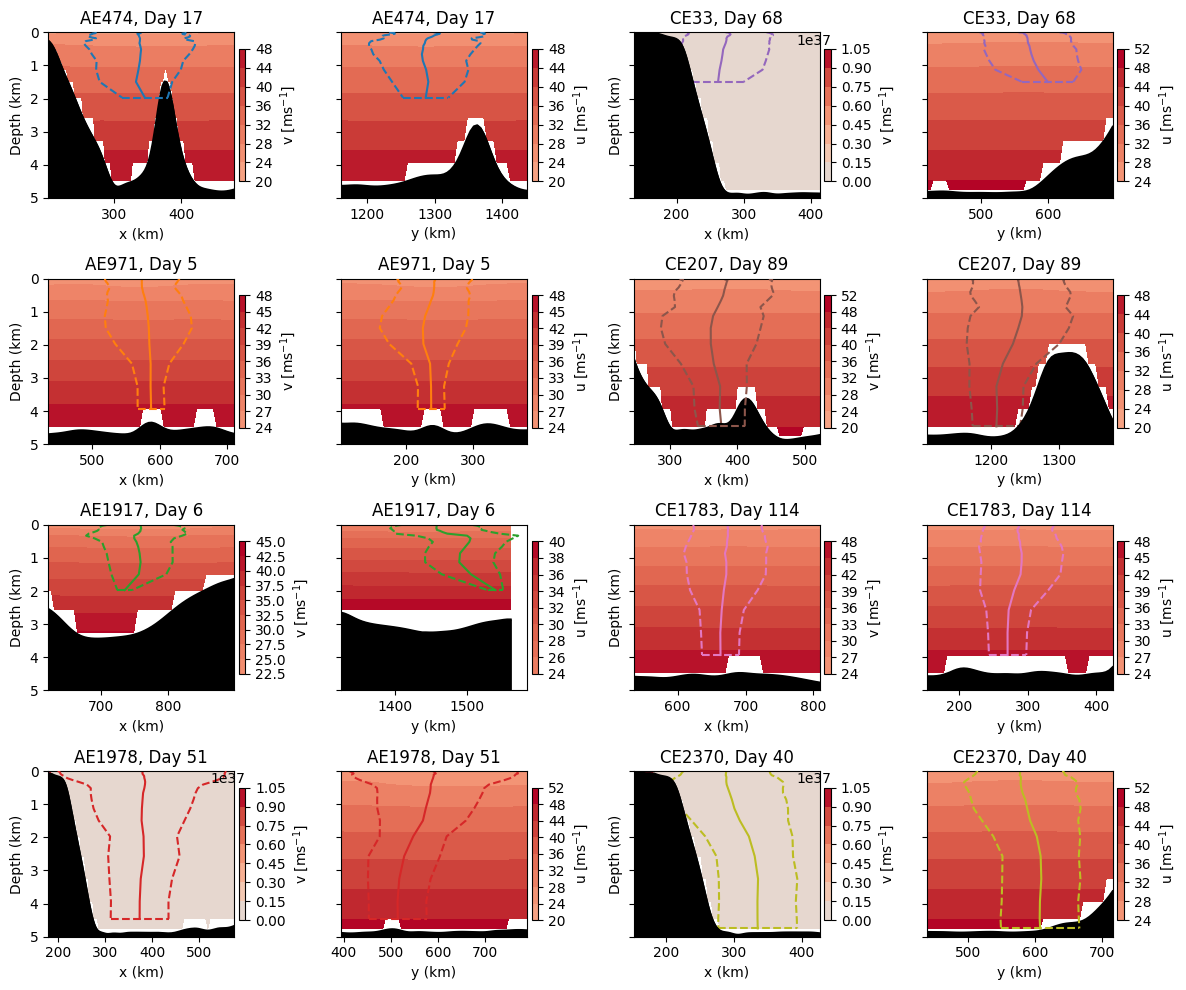

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)
# colors = plt.get_cmap('tab10').colors
fnumber_old = None
day_idx_p = [17, 5, 6, 51, 
             68, 89, 114, 40]

for e, (eddy, day_idx) in enumerate(zip(sample_eddies, day_idx_p)):
    
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    r = 140 if eddy != 1978 else 200

    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax0.set_title(f'{cyc}{eddy}, Day {day_idx}')
    ax1.set_title(f'{cyc}{eddy}, Day {day_idx}')
    
    dic = dic_sample[f'Eddy{eddy}']
    day = list(dic.keys())[day_idx]
    df = dic[day].copy()

    Rcs = df.Rc.values.copy()
    depths = -df.Depth.values.copy() / 1000  # in km
    df['sRc']   = smooth(Rcs, depths, window=50, num=1000)

    day = int(day[3:])
        
    fname = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']
    fnumber = fname[-8:-3]
    if fnumber != fnumber_old:
        rho_raw = np.load('/srv/scratch/z5297792/Climatology/rhos/rho_' + fnumber + '.npy')
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == day)[0][0]
    
    rho_t = rho_raw[:, :, :, t_rel]
    
    xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
    ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
    jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]
    
    x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
    y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
    # symmetric limits
    vmax_v = np.nanmax(np.abs(rho_t[x_mask, jc, :]))
    vmax_u = np.nanmax(np.abs(rho_t[ic, y_mask, :]))
    
    # v‐slice
    im0 = ax0.contourf(
        x_grid[x_mask],
        -z_r[150,150,:]/1000,
        rho_t[x_mask, jc, :].T,
        cmap='coolwarm',
        vmin=-vmax_v,
        vmax=+vmax_v,
        zorder=0
    )
    ax0.plot(df.x, -df.Depth/1000, color=colors[e%len(colors)])
    ax0.plot(df.x+df.sRc, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.plot(df.x-df.sRc, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.plot([df.iloc[-1].x-df.iloc[-1].sRc, df.iloc[-1].x+df.iloc[-1].sRc],
             [-df.iloc[-1].Depth/1000, -df.iloc[-1].Depth/1000],
             color=colors[e%len(colors)], ls='--', zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.set_xlabel('x (km)')
    ax0.set_ylabel('Depth (km)')
    ax0.plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k', zorder=2)
    ax0.fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k', zorder=2)
    ax0.set_ylim(ax0.get_ylim())
    
    # vertical colourbar on the right
    cbar0 = fig.colorbar(
        im0,
        ax=ax0,
        orientation='vertical',  # default but explicit here
        pad=0.02,                # small gap to the right
        shrink=0.8               # scale to fit subplot height
    )
    cbar0.set_label(r'v [ms$^{-1}$]')
    
    # u‐slice
    im1 = ax1.contourf(
        y_grid[y_mask],
        -z_r[150,150,:]/1000,
        rho_t[ic, y_mask, :].T,
        cmap='coolwarm',
        vmin=-vmax_u,
        vmax=+vmax_u,
        zorder=0
    )
    ax1.plot(df.y, -df.Depth/1000, color=colors[e])
    ax1.plot(df.y+df.sRc, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.plot(df.y-df.sRc, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.plot([df.iloc[-1].y-df.iloc[-1].sRc, df.iloc[-1].y+df.iloc[-1].sRc],
             [-df.iloc[-1].Depth/1000, -df.iloc[-1].Depth/1000], 
             color=colors[e%len(colors)], ls='--', zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.set_xlabel('y (km)')
    ax1.plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k', zorder=2)
    ax1.fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k', zorder=2)
    ax1.set_ylim(0, 5)
    
    # vertical colourbar on the right
    cbar1 = fig.colorbar(
        im1,
        ax=ax1,
        orientation='vertical',
        pad=0.02,
        shrink=0.8
    )
    cbar1.set_label(r'u [ms$^{-1}$]')

# invert y once at the end
axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


For each eddy-day, I will interpolate the rho at each vertical center. 


In [7]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumber:05}.nc'
dataset = nc.Dataset(fname)

rho = dataset.variables['rho']
rho = np.transpose(rho, axes=(3, 2, 1, 0))
rho = np.flip(rho, axis=2)


In [8]:
df = dic_sample['Eddy33']['Day1567'].copy()

ics, jcs = find_icjc(df.x, df.y, X_grid, Y_grid)
df['ic'], df['jc'] = ics, jcs
df


,x,y,Q,w,Rc,psi0,z,Depth,TD,ic,jc
0,345.213866,1056.432095,"[[-0.009819706791509331, -0.002815675603400271...",-0.000030,76.416137,269.034350,0,-1.783320,0.000000,132,214
1,346.525741,1055.080883,"[[-0.01000942651966925, -0.0029358297130947413...",-0.000031,76.427204,145.562525,1,-5.879627,1.883291,132,214
2,347.012064,1055.104043,"[[-0.009986027967841685, -0.003027790293908267...",-0.000030,76.430017,119.628398,2,-10.725783,2.235450,132,214
3,347.080578,1055.297183,"[[-0.00995605191419466, -0.0030021509195423475...",-0.000030,75.190875,182.310597,3,-16.383097,2.184637,133,214
4,347.071128,1055.370794,"[[-0.009944828009964364, -0.002980231978396445...",-0.000031,75.190194,181.326981,4,-22.925581,2.139108,133,214
5,347.083602,1055.344890,"[[-0.009930573298316465, -0.002979644226452476...",-0.000031,75.190355,165.724963,5,-30.444118,2.162852,133,214
6,347.148151,1055.360160,"[[-0.009917094981817053, -0.003204199183871689...",-0.000031,77.038015,128.113632,6,-39.052712,2.211448,133,214
7,347.015761,1055.753475,"[[-0.009869547734012078, -0.003220375959579923...",-0.000031,79.106357,114.684743,7,-48.897638,1.925448,132,214
8,346.525035,1056.385922,"[[-0.009548607846325559, -0.002886855264774868...",-0.000030,80.350669,150.184939,8,-60.170639,1.311981,132,214
9,345.899797,1055.143627,"[[-0.009303763056832346, -0.002842713458073058...",-0.000029,80.981874,119.975277,9,-73.127842,1.459675,132,214


In [25]:
dic_rho_sample = {}
for eddy in sample_eddies:
    dic = dic_sample[f'Eddy{eddy}'].copy()
    dic_rho_sample[f'Eddy{eddy}'] = {}
    
    fname_old = None
    ocean_time = None
    rho = None  
    
    for day_key in dic.keys():                 
        day = int(day_key[3:])                    
    
        surf_data = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies.Day == day)].iloc[0]
        df = dic[f'Day{day}'].copy()
    
        ics, jcs = find_icjc(df.x, df.y, X_grid, Y_grid)
        df['ic'] = ics
        df['jc'] = jcs
    
        fname = surf_data.fname
        if fname != fname_old:
            with nc.Dataset(fname) as ds:
                rho = ds.variables['rho']
                rho = np.transpose(rho, axes=(3, 2, 1, 0))
                rho = np.flip(rho, axis=2)
                ocean_time = ds.variables['ocean_time'][:].data / 86400.0  # days
            fname_old = fname
    
        # Find nearest time index robustly (avoid float equality)
        t_rel = int(np.argmin(np.abs(ocean_time - day)))
    
        den_interps = []
        for k, row in df.iterrows():
            ic = int(row.ic)
            jc = int(row.jc)
    
            if ic < 0 or jc < 0:
                den_interps.append(np.nan)
                continue
    
            densities = rho[ic, jc, :, t_rel]     # shape (z,)
            depths = z_r[ic, jc, :]               # shape (z,)
    
            # Ensure strictly increasing depths for np.interp
            if depths[0] > depths[-1]:
                depths = depths[::-1]
                densities = densities[::-1]
    
            target_depth = row.Depth
            if not np.isfinite(target_depth):
                den_interps.append(np.nan)
                continue
    
            # Clip to bounds to avoid NaN from extrapolation
            dmin, dmax = depths[0], depths[-1]
            td = np.clip(target_depth, dmin, dmax)
            den_interps.append(np.interp(td, depths, densities))
    
        df['rho'] = den_interps
        dic_rho_sample[f'Eddy{eddy}'][f'Day{day}'] = df


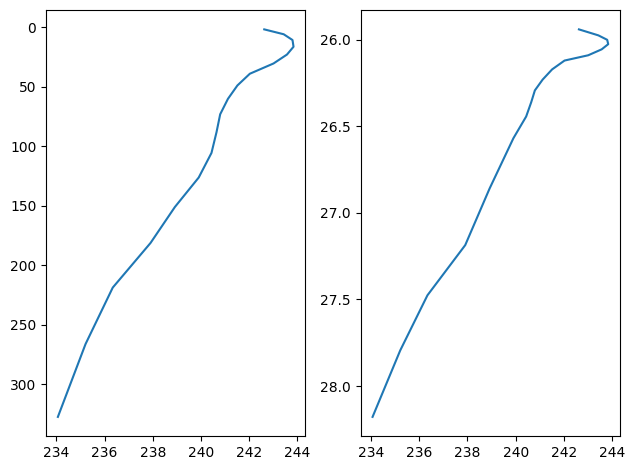

In [27]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(df.x, -df.Depth)
axs[0].invert_yaxis()
axs[1].plot(df.x, df.rho)
axs[1].invert_yaxis()
plt.tight_layout()


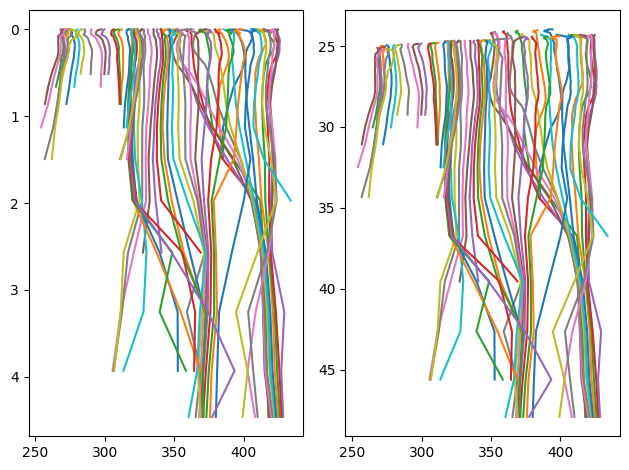

In [28]:
eddy = 33
fig, axs = plt.subplots(1, 2)
for day in dic_rho_sample[f'Eddy{eddy}']:
    df = dic_rho_sample[f'Eddy{eddy}'][day]
    axs[0].plot(df.x, -df.Depth/1000)
    axs[1].plot(df.x, df.rho)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
plt.tight_layout()
        

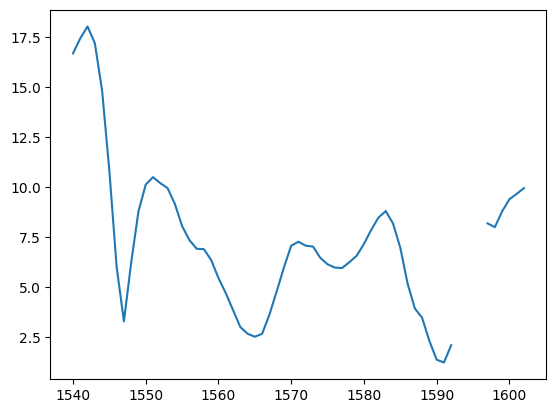

In [29]:
df = df_eddies[df_eddies.Eddy==eddy]
plt.plot(df.Day, df.TiltDis)


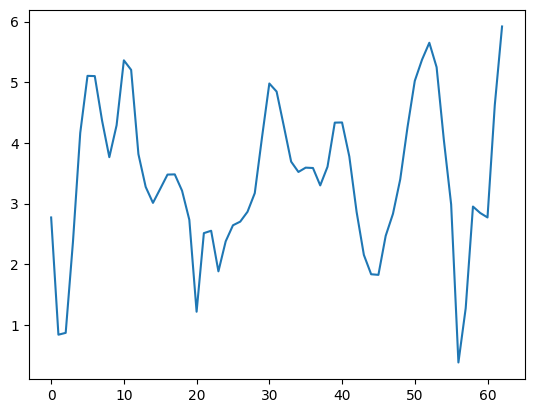

In [45]:
df_rho_tilt = compute_tilt_data(dic_rho_sample[f'Eddy{eddy}'], eddy, num=6, depth_int=0.05, max_depth=30, var='rho')
plt.plot(df_rho_tilt.TiltDis)
